#### Import everything you need

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical as make_class_categorical
import _pickle as pickle
from tqdm import tqdm
import os

Using TensorFlow backend.


#### Ring a bell!

In [3]:
def inform_exit():
    
    os.system('say "Training process is completed"')

In [4]:
def LoadBatch(filename):
    """
    Loads batch based on the given filename and produces the X, Y, and y arrays

    :param filename: Path of the file
    :return: X, Y and y arrays
    """

    # borrowed from https://www.cs.toronto.edu/~kriz/cifar.html
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    dictionary = unpickle(filename)

    # borrowed from https://stackoverflow.com/questions/16977385/extract-the-nth-key-in-a-python-dictionary?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    def ix(dic, n):  # don't use dict as  a variable name
        try:
            return list(dic)[n]  # or sorted(dic)[n] if you want the keys to be sorted
        except IndexError:
            print('not enough keys')

    garbage = ix(dictionary, 1)
    y = dictionary[garbage]
    Y = np.transpose(make_class_categorical(y, 10))
    garbage = ix(dictionary, 2)
    X = np.transpose(dictionary[garbage]) / 255

    return X, Y, y

#### Weight initialization

In [5]:
def initialize_weights(shapes_list, std=0.001):
    """
    Initializes the weight and bias arrays for the 2 layers of the network

    :param shapes_list: List that contains the shapes of the weight matrices of each layer. The number of layers can be found through
                        estimating the length of this list.
    :param variance (optional): The variance of the normal distribution that will be used for the initialization of the weights

    :return: Weights and bias arrays for each layer of the network stored in lists
    """

    np.random.seed(400)

    weights = []
    biases = []

    for shape in shapes_list:

        W = np.random.normal(0, std, size=(shape[0], shape[1]))
        b = np.zeros(shape=(shape[0], 1))

        weights.append(W)
        biases.append(b)

    return weights, biases

In [6]:
def he_initialization_k_layers(shapes_list):
    """
    He initialization on the weight matrices.

    :param shapes_list: List that contains the dimensions of each layer of the network.

    :return: Initialized weight and bias matrices based on He initialization of the weights.
    """

    weights = []
    biases = []

    for pair in shapes_list:

        weights.append(np.random.randn(pair[0], pair[1]) * np.sqrt(2 / float(pair[0])))
        biases.append(np.zeros(shape=(pair[0], 1)))

    return weights, biases


#### Activation function

In [7]:
def ReLU(x):
    """
    Rectified Linear Unit function

    :param x: Input to the function

    :return: Output of ReLU(x)
    """

    return np.maximum(x, 0)

#### Classifier Evaluation

In [8]:
def softmax(X, theta=1.0, axis=None):
    """
    Softmax over numpy rows and columns, taking care for overflow cases
    Many thanks to https://nolanbconaway.github.io/blog/2017/softmax-numpy
    Usage: Softmax over rows-> axis =0, softmax over columns ->axis =1

    :param X: ND-Array. Probably should be floats.
    :param theta: float parameter, used as a multiplier prior to exponentiation. Default = 1.0
    :param axis (optional): axis to compute values along. Default is the first non-singleton axis.

    :return: An array the same size as X. The result will sum to 1 along the specified axis
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [9]:
def predictClasses(p):
    """
    Predicts classes based on the softmax output of the network

    :param p: Softmax output of the network
    :return: Predicted classes
    """

    return np.argmax(p, axis=0)

In [10]:
def BatchNormalize(s, mean_s, var_s, epsilon=1e-20):
    """
    Normalizes the scores of a batch based on their mean and variance.

    :param s: Scores evaluated as output of a layer of the network.
    :param mean_s: Mean of the scores.
    :param var_s: Variance of the scores.
    :param epsilon: A small number that is present to ensure that no division by zero will be performed.

    :return: The normalized scores,
    """

    diff = s - mean_s

    return diff / (np.sqrt(var_s + epsilon))

In [28]:
def ForwardPassBatchNormalization(X, weights, biases, exponentials= None, mode=1):
    """
    Evaluates the forward pass result of the classifier network using batch normalization.

    :param X: Input data.
    :param weights: Weight arrays of the k-layer network.
    :param biases: Bias vectors of the k-layer network.
    :param mode: Pre-set to 1 to perform batch normalisation before the activation function,
                 change to any other value to apply BN after the activation function.
    :param exponential: The exponential moving means and averages.

    :return: Softmax probabilities (predictions) of the true labels of the data.
    """

    s = np.dot(weights[0], X) + biases[0]

    intermediate_outputs = [s]

    if mode == 1:
        # Applying batch normalisation before the activation function.
        if exponentials is not None:

            exponential_means = exponentials[0]
            exponential_variances = exponentials[1]

            mean_s = exponential_means[0]
            var_s = exponential_variances[0]

        else:

            mean_s = s.mean(axis=1).reshape(s.shape[0], 1)
            var_s = s.var(axis=1).reshape(s.shape[0], 1)

            means = [mean_s]
            variances = [var_s]

        normalized_score = BatchNormalize(s, mean_s, var_s)

        batch_normalization_outputs = [normalized_score]
        batch_normalization_activations = [ReLU(normalized_score)]
    else:
        # Applying batch normalisation after the activation function, variable names are not changed for practical reasons.
        batch_normalization_outputs = [ReLU(s)]

        if exponentials is not None:

            exponential_means = exponentials[0]
            exponential_variances = exponentials[1]

            mean_s = exponential_means[0]
            var_s = exponential_variances[0]

        else:

            mean_s = s.mean(axis=1).reshape(s.shape[0], 1)
            var_s = s.var(axis=1).reshape(s.shape[0], 1)

            means = [mean_s]
            variances = [var_s]

        normalized_score = BatchNormalize(batch_normalization_outputs[-1], mean_s, var_s)
        batch_normalization_activations = [normalized_score]

    for index in range(1, len(weights) - 1):

        s = np.dot(weights[index], batch_normalization_activations[-1]) + biases[index]

        intermediate_outputs.append(s)

        if mode == 1:
            # Applying batch normalisation before the activation function.
            if exponentials is not None:

                mean_s = exponential_means[index]
                var_s = exponential_variances[index]

            else:

                mean_s = s.mean(axis=1).reshape(s.shape[0], 1)
                var_s = s.var(axis=1).reshape(s.shape[0], 1)

                means.append(means)
                variances.append(var_s)

            normalized_score = BatchNormalize(s, mean_s, var_s)

            batch_normalization_outputs = [normalized_score]
            batch_normalization_activations = [ReLU(normalized_score)]
        else:
            # Aplying batch normalisation after the activation function, variable names are not changed for practical reasons.
            batch_normalization_outputs.append(ReLU(s))

            if exponentials is not None:

                mean_s = exponential_means[index]
                var_s = exponential_variances[index]

            else:

                mean_s = s.mean(axis=1).reshape(s.shape[0], 1)
                var_s = s.var(axis=1).reshape(s.shape[0], 1)

                means.append(mean_s)
                variances.append(var_s)

            normalized_score = BatchNormalize(batch_normalization_outputs[-1], mean_s, var_s)
            batch_normalization_activations.append(normalized_score)

    s = np.dot(weights[-1], batch_normalization_activations[-1]) + biases[-1]

    p = softmax(s, axis=0)

    if exponentials is not None:
        return p
    else:
        return p, batch_normalization_activations, batch_normalization_outputs, intermediate_outputs, means, variances

In [26]:
def ComputeAccuracyBatchNormalization(X, y, weights, biases, exponentials = None, mode =1):
    """
    Computes the accuracy of the feed-forward k-layer network

    :param X: Input data
    :param weights: Weights arrays of the k layers
    :param biases: Bias vectors of the k layers
    :param exponentials: Contains the exponential means and variances computed, they are used in call after training.

    :return: Accuracy performance of the neural network.
    """
    if exponentials is not None:
        p = ForwardPassBatchNormalization(X, weights, biases, exponentials, mode=mode)
    else:
        p = ForwardPassBatchNormalization(X, weights, biases, exponentials, mode=mode)[0]
    predictions = predictClasses(p)

    accuracy = round(np.sum(np.where(predictions - y == 0, 1, 0)) * 100 / len(y), 2)

    return accuracy

#### Compute Cost

In [35]:
def ComputeCostBatchNormalization(X, Y, weights, biases, regularization_term, exponentials=None, mode=1):
    """
    Computes the cross-entropy loss on a batch of data.

    :param X: Input data
    :param y: Labels of the ground truth
    :param weights: Weights arrays of the k layers
    :param biases: Bias vectors of the k layers
    :param regularization_term: Amount of regularization applied.
    :param exponentials: (Optional) Contains the exponential means and variances computed, they are used in call after training.

    :return: Cross-entropy loss.
    """

    if exponentials is not None:
        p = ForwardPassBatchNormalization(X, weights, biases, exponentials, mode=mode)
    else:
        p = ForwardPassBatchNormalization(X, weights, biases, exponentials, mode=mode)[0]

    cross_entropy_loss = -np.log(np.diag(np.dot(Y.T, p))).sum() / float(X.shape[1])

    weight_sum = 0
    for weight in weights:

        weight_sum += np.power(weight, 2).sum()

    return cross_entropy_loss + regularization_term * weight_sum

#### Momentum

In [14]:
def initialize_momentum(arrays):
    """
    Initializes the momentum arrays to zero numpy arrays.
    
    :param matrices: Weights or bias that need corresponding momentum arrays.
    :return: Numpy zeros for each layer of the same shape
    """
    momentum_matrices = []
    for elem in arrays:
        momentum_matrices.append(np.zeros(elem.shape))
    return momentum_matrices

In [15]:
def add_momentum(weights, grad_weights, momentum_weights, biases, grad_biases, momentum_biases, eta, momentum_term):
    """
    Add momentum to an array (weight or bias) of the network.

    :param weights: The weight matrices of the k layers.
    :param grad_weights: The gradient updatea of the weights.
    :param momentum_weights: Momentum arrays (v) of the weights.
    :param biases: The bias vector of the k layers.
    :param grad_biases: The gradient updates for the biases.
    :param momentum_biases: Momentum vectors (v) of the weights.
    :param eta: Learning rate of the network.
    :param momentum_term: Amount of momentum to be taken into account in the updates.

    :return: Updated weights and biases of the network with momentum contribution, updated momentumm arrays for the
             weights and biases of the network.
    """

    updated_weights = []
    updated_biases = []

    for index in range(len(weights)):

        new_momentum_weight = momentum_term * momentum_weights[index] + eta * grad_weights[index]
        momentum_weights[index] = new_momentum_weight
        updated_weights.append(weights[index] - new_momentum_weight)

        new_momentum_bias = momentum_term * momentum_biases[index] + eta * grad_biases[index]
        momentum_biases[index] = new_momentum_bias
        updated_biases.append(biases[index] - new_momentum_bias)


    return updated_weights, updated_biases, momentum_weights, momentum_biases


#### Backward pass and compute gradients

In [16]:
def BatchNormBackPass(g, s, mean_s, var_s, epsilon=1e-20):

    # First part of the gradient:
    V_b = (var_s+ epsilon) ** (-0.5)
    part_1 = g * V_b

    # Second part pf the gradient
    diff = s - mean_s
    grad_J_vb = -0.5 * np.sum(g * (var_s+epsilon) ** (-1.5) * diff, axis=1)
    grad_J_vb = np.expand_dims(grad_J_vb, axis=1)
    part_2 = (2/float(s.shape[1])) * grad_J_vb * diff

    # Third part of the gradient
    grad_J_mb = -np.sum(g * V_b, axis=1)
    grad_J_mb = np.expand_dims(grad_J_mb, axis=1)
    part_3 = grad_J_mb / float(s.shape[1])

    return part_1 + part_2 + part_3

In [17]:
def BackwardPassBatchNormalization(X, Y, weights, biases, p, bn_outputs, bn_activations, intermediate_outputs, means, variances, regularization_term):

    # Back-propagate output layer at first

    g = p - Y

    bias_updates = [g.sum(axis=1).reshape(biases[-1].shape)]
    weight_updates = [np.dot(g, bn_activations[-1].T)]

    g = np.dot(g.T, weights[-1])
    ind = 1 * (bn_outputs[-1] > 0)
    g = g.T * ind

    for i in reversed(range(len(weights) -1)):
    # Back-propagate the gradient vector g to the layer before

        g = BatchNormBackPass(g, intermediate_outputs[i], means[i], variances[i])

        if i == 0:
            weight_updates.append(np.dot(g, X.T))
            bias_updates.append(np.sum(g, axis=1).reshape(biases[i].shape))
            break
        else:
            weight_updates.append(np.dot(g, bn_activations[i-1].T))
            bias_updates.append(np.sum(g, axis=1).reshape(biases[i].shape))

        g = np.dot(g.T, weights[i])
        ind = 1 * (bn_outputs[i-1] > 0)
        g = g.T * ind


    for elem in weight_updates:
        elem /= X.shape[1]

    for elem in bias_updates:
        elem /= X.shape[1]

    # Reverse the updates to match the order of the layers
    weight_updates = list(reversed(weight_updates)).copy()
    bias_updates = list(reversed(bias_updates)).copy()

    for index in range(len(weight_updates)):
        weight_updates[index] += 2*regularization_term * weights[index]

    return weight_updates, bias_updates

In [18]:
def ExponentialMovingAverage(means, exponential_means, variances, exponential_variances, a=0.99):

    for index, elem in enumerate(exponential_means):

        exponential_means[index] = a * elem + (1-a) * means[index]
        exponential_variances[index] = a * exponential_variances[index] + (1-a) * variances[index]

    return exponential_means, exponential_variances

#### Visualization functions

In [19]:
def visualize_plots(train, validation, display=False, title=None, save_name=None, save_path='../figures/'):
    """
    Visualization and saving plots (losses and accuracies) of the network.

    :param train: Loss of accuracy of the training data.
    :param validation: Loss of accuracy of the validation data.
    :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
    :param title: (Optional) Title of the plot.
    :param save_name: (Optional) name of the file to save the plot.
    :param save_path: (Optional) Path of the folder to save the plot in your local computer.

    :return: None

    """

    if title is not None:
        plt.title(title)

    plt.plot(train, 'g', label='Training set ')
    plt.plot(validation, 'r', label='Validation set')
    plt.legend(loc='upper right')

    if save_name is not None:
        if save_path[-1] != '/':
            save_path += '/'
        plt.savefig(save_path + save_name)

    if display:
        plt.show()

    plt.clf()

#### MiniBatch gradient descent

In [48]:
def MiniBatchGDBatchNormalization(training_set, validation_set, GDparams, weights, biases, mode=1, with_augmenting=False, momentum_term=0.9):
    """
    Performs mini batch-gradient descent computations with batch normalization.

    :param training_set: Training data.
    :param validation_set: Validation data.
    :param GDparams: Gradient descent parameters (number of mini batches to construct, learning rate, epochs, amount of regularization to be applied)
    :param weights: Weight matrices of the k layers
    :param biases: Bias vectors of the k layers
    :param mode: (Optional) Preset to 1 apply batch normalisation before the activation function, change to any value so 
                 that batch normalisation will be applied after the activation function.
    :param with_augmenting: (Optional) Change to True to apply a small amount of random noise on the fly to the batch 
                            based on its standard deviation.
    :param momentum_term: Amount of previous update to be taken into account in SGD.        

    :return: The weight and bias matrices learnt (trained) from the training process,
             loss in training and validation set, accuracy evolution in training and validation set.
    """
    [number_of_mini_batches, eta, epoches, regularization_term] = GDparams

    [X, Y, y], [X_validation, Y_validation, y_validation] = training_set, validation_set

    train_loss_evolution, validation_loss_evolution = [], []
    train_accuracy_evolution, validation_accuracy_evolution = [], []

    momentum_weights, momentum_biases = initialize_momentum(weights), initialize_momentum(biases)

    best_weights, best_biases, best_validation_set_accuracy = weights, biases, 0
    exponentials, best_exponentials = [], []

    for epoch in tqdm(range(epoches)):
    # for epoch in range(epoches):

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):
            start = (batch - 1) * number_of_mini_batches
            end = min(batch * number_of_mini_batches + int(X.shape[1] / number_of_mini_batches), X.shape[1] )

            if with_augmenting:
                # Apply noise to the data
                random_noise = np.random.normal(0, 0.0001 * np.std(X), size= X.shape)
                X += random_noise

            p, batch_norm_activations, batch_norm_outputs, intermediate_outputs, means, variances = ForwardPassBatchNormalization(X[:, start:end], weights, biases, mode=mode)

            grad_weights, grad_biases = BackwardPassBatchNormalization(X[:, start:end], Y[:, start:end], weights, biases, p, batch_norm_outputs, batch_norm_activations, intermediate_outputs, means, variances, regularization_term)

            weights, biases, momentum_weights, momentum_biases = add_momentum(weights, grad_weights, momentum_weights, biases, grad_biases, momentum_biases, eta, momentum_term)

            if epoch == 0 and start == 0:
                exponential_means = means.copy()
                exponential_variances = variances.copy()
                exponentials, best_exponentials = [exponential_means, exponential_variances], [exponential_means, exponential_variances]
            else:
                exponentials = ExponentialMovingAverage(means, exponentials[0], variances, exponentials[1])

        epoch_cost = ComputeCostBatchNormalization(X, Y, weights, biases, regularization_term, exponentials=exponentials, mode=mode)
        val_epoch_cost = ComputeCostBatchNormalization(X_validation, Y_validation, weights, biases, regularization_term, exponentials=exponentials, mode=mode)

        train_loss_evolution.append(epoch_cost)
        validation_loss_evolution.append(val_epoch_cost)

        train_accuracy_evolution.append(ComputeAccuracyBatchNormalization(X, y, weights, biases, exponentials, mode))
        validation_accuracy_evolution.append(ComputeAccuracyBatchNormalization(X_validation, y_validation, weights, biases, exponentials, mode))

        if validation_accuracy_evolution[-1] > best_validation_set_accuracy:

            best_weights, best_biases, best_validation_set_accuracy = weights, biases, validation_accuracy_evolution[-1]
            best_exponentials = exponentials

        # Decay the learning rate
        eta *= 0.95

    return best_weights, best_biases, [train_loss_evolution, validation_loss_evolution], [train_accuracy_evolution, validation_accuracy_evolution], best_exponentials

#### Extract all data in the training set 

In [32]:
def create_sets():
    """
    Creates the full dataset, containing all the available data for training except 1000 images
    used for the validation set.

    :return: Training, validation and test sets (features, ground-truth labels, and their one-hot representation
    """

    X_training_1, Y_training_1, y_training_1 = LoadBatch('../../cifar-10-batches-py/data_batch_1')
    X_training_2, Y_training_2, y_training_2 = LoadBatch('../../cifar-10-batches-py/data_batch_2')
    X_training_3, Y_training_3, y_training_3 = LoadBatch('../../cifar-10-batches-py/data_batch_3')
    X_training_4, Y_training_4, y_training_4 = LoadBatch('../../cifar-10-batches-py/data_batch_4')
    X_training_5, Y_training_5, y_training_5 = LoadBatch('../../cifar-10-batches-py/data_batch_5')

    X_training = np.concatenate((X_training_1, X_training_3), axis=1)
    X_training = np.copy(np.concatenate((X_training, X_training_4), axis=1))
    X_training = np.copy(np.concatenate((X_training, X_training_5), axis=1))

    X_training = np.concatenate((X_training, X_training_2[:, :9000]), axis=1)

    Y_training = np.concatenate((Y_training_1, Y_training_3), axis=1)
    Y_training = np.copy(np.concatenate((Y_training, Y_training_4), axis=1))
    Y_training = np.copy(np.concatenate((Y_training, Y_training_5), axis=1))

    Y_training = np.concatenate((Y_training, Y_training_2[:, :9000]), axis=1)

    y_training = y_training_1 + y_training_3 + y_training_4 + y_training_5 + y_training_2[:9000]

    X_validation = np.copy(X_training_2[:, 9000:])
    Y_validation = np.copy(Y_training_2[:, 9000:])
    y_validation = y_training_2[9000:]

    X_test, _, y_test = LoadBatch('../../cifar-10-batches-py/test_batch')

    mean = np.mean(X_training)
    X_training -= mean
    X_validation -= mean
    X_test -= mean

    return [X_training, Y_training, y_training], [X_validation, Y_validation, y_validation], [X_test, y_test]

### BONUS EXERCISE 1: Try improvements on your k-layer network

#### Improvement 1: Try to perform batch normalisation after the activation function is applied

In [33]:
training_set, validation_set, test_set = create_sets()

Setting 1

In [36]:
cnt = 0

eta, regularization_term = 0.034875895633392565, 1e-05

GD_params = [100, eta, 10, regularization_term]

weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

best_weights, best_biases, losses, accuracies, exponentials = \
    MiniBatchGDBatchNormalization(training_set, validation_set, GD_params, weights, biases, mode=2)
inform_exit()

100%|██████████| 10/10 [14:12<00:00, 85.25s/it]


Cross-entropy loss evolution:

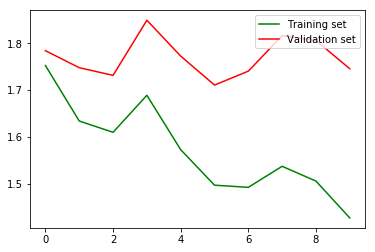

<Figure size 432x288 with 0 Axes>

In [37]:
visualize_plots(losses[0], losses[1], display= True, save_name=f'im_1_{cnt}_losses.png')

Accuracy performance evolution:

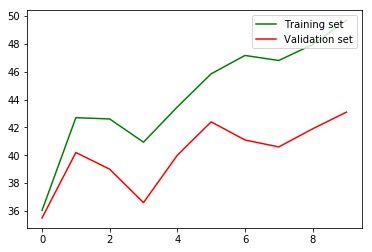

<Figure size 432x288 with 0 Axes>

In [38]:
visualize_plots(accuracies[0], accuracies[1], display= True, save_name=f'im_1_{cnt}_accuracies.png')

Test-set accuracy performance:

In [39]:
ComputeAccuracyBatchNormalization(test_set[0], test_set[1], best_weights, best_biases, exponentials=exponentials, mode=2)

43.34

Setting 2

In [40]:
cnt += 1

eta, regularization_term = 0.007986719995840757, 1e-06

GD_params = [100, eta, 10, regularization_term]

weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

best_weights, best_biases, losses, accuracies, exponentials = \
    MiniBatchGDBatchNormalization(training_set, validation_set, GD_params, weights, biases, mode=2)
inform_exit()

100%|██████████| 10/10 [14:25<00:00, 86.53s/it]


Cross-entropy loss evolution:

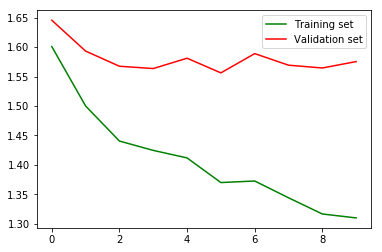

<Figure size 432x288 with 0 Axes>

In [41]:
visualize_plots(losses[0], losses[1], display= True, save_name=f'im_1_{cnt}_losses.png')

Accuracy performance evolution:

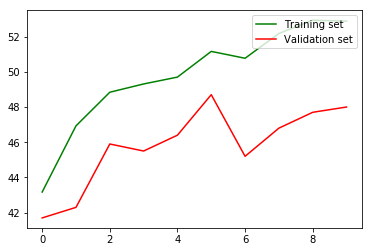

<Figure size 432x288 with 0 Axes>

In [42]:
visualize_plots(accuracies[0], accuracies[1], display= True, save_name=f'im_1_{cnt}_accuracies.png')

Test-set accuracy performance:

In [43]:
ComputeAccuracyBatchNormalization(test_set[0], test_set[1], best_weights, best_biases, exponentials=exponentials, mode=2)

39.23

Setting 3

In [44]:
cnt += 1

eta, regularization_term = 0.012913581489067944, 1e-04

GD_params = [100, eta, 10, regularization_term]

weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

best_weights, best_biases, losses, accuracies, exponentials = \
    MiniBatchGDBatchNormalization(training_set, validation_set, GD_params, weights, biases, mode=2)
inform_exit()

100%|██████████| 10/10 [14:40<00:00, 88.07s/it]


Cross-entropy loss evolution:

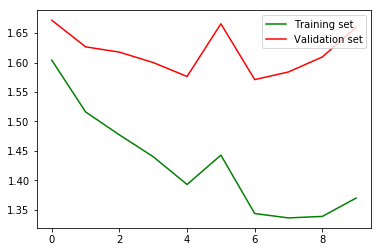

<Figure size 432x288 with 0 Axes>

In [45]:
visualize_plots(losses[0], losses[1], display= True, save_name=f'im_1_{cnt}_losses.png')

Accuracy performance evolution:

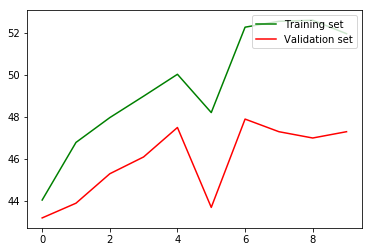

<Figure size 432x288 with 0 Axes>

In [46]:
visualize_plots(accuracies[0], accuracies[1], display= True, save_name=f'im_1_{cnt}_accuracies.png')

Test-set accuracy performance:

In [47]:
ComputeAccuracyBatchNormalization(test_set[0], test_set[1], best_weights, best_biases, exponentials=exponentials, mode=2)

43.83

#### Improvement 2: Augmenting  the input data by applying a small random noise on the fly

Setting 1

In [53]:
eta, regularization_term = 0.034875895633392565, 1e-05

GD_params = [100, eta, 10, regularization_term]

weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

best_weights, best_biases, losses, accuracies, exponentials = \
MiniBatchGDBatchNormalization(training_set, validation_set, GD_params, weights, biases, with_augmenting=True)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:45<15:50, 105.59s/it]

 20%|██        | 2/10 [03:07<12:30, 93.80s/it] 

 30%|███       | 3/10 [04:36<10:45, 92.24s/it]

 40%|████      | 4/10 [06:02<09:04, 90.74s/it]

 50%|█████     | 5/10 [07:30<07:30, 90.20s/it]

 60%|██████    | 6/10 [08:52<05:54, 88.73s/it]

 70%|███████   | 7/10 [10:23<04:27, 89.05s/it]

 80%|████████  | 8/10 [11:51<02:57, 89.00s/it]

 90%|█████████ | 9/10 [13:20<01:28, 88.94s/it]

100%|██████████| 10/10 [14:54<00:00, 89.50s/it]



Cross-entropy loss evolution:

In [54]:
visualize_plots(losses[0], losses[1], save_name='aug_{cnt}_losses.png')

<Figure size 432x288 with 0 Axes>

Accuracy performance evolution:

In [55]:
visualize_plots(accuracies[0], accuracies[1], save_name='aug_1_{cnt}_accuracies.png')

<Figure size 432x288 with 0 Axes>

Test set accuracy:

In [56]:
ComputeAccuracyBatchNormalization(test_set[0], test_set[1], best_weights, best_biases, exponentials=exponentials, mode=2)

13.79

Setting 2

In [ ]:
eta, regularization_term = 0.007986719995840757, 1e-06

GD_params = [100, eta, 10, regularization_term]

weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

best_weights, best_biases, losses, accuracies, exponentials = \
    MiniBatchGDBatchNormalization(training_set, validation_set, GD_params, weights, biases, with_augmenting=True)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:40<15:00, 100.06s/it]

 20%|██        | 2/10 [03:15<13:03, 97.96s/it] 

 30%|███       | 3/10 [04:48<11:12, 96.01s/it]

 40%|████      | 4/10 [06:21<09:32, 95.46s/it]

 50%|█████     | 5/10 [07:51<07:51, 94.29s/it]

 60%|██████    | 6/10 [09:35<06:23, 95.87s/it]

 70%|███████   | 7/10 [11:16<04:49, 96.59s/it]

Cross-entropy loss evolution:

In [ ]:
visualize_plots(losses[0], losses[1], save_name='aug_{cnt}_losses.png')

Accuracy performance evolution:

In [ ]:
visualize_plots(accuracies[0], accuracies[1], save_name='aug_1_{cnt}_accuracies.png')

Test set accuracy:

In [ ]:
ComputeAccuracyBatchNormalization(test_set[0], test_set[1], best_weights, best_biases, exponentials=exponentials, mode=2)

Setting 3

In [ ]:
eta, regularization_term = 0.012913581489067944, 1e-04

GD_params = [100, eta, 10, regularization_term]

weights, biases = initialize_weights([[50, 3072], [30, 50], [10, 30]])

best_weights, best_biases, losses, accuracies, exponentials = \
MiniBatchGDBatchNormalization(training_set, validation_set, GD_params, weights, biases, mode=2, with_augmenting=True)

Cross-entropy loss evolution:

In [ ]:
visualize_plots(losses[0], losses[1], save_name='aug_{cnt}_losses.png')

Accuracy performance evolution:

In [ ]:
visualize_plots(accuracies[0], accuracies[1], save_name='aug_1_{cnt}_accuracies.png')

Test set accuracy:

In [ ]:
ComputeAccuracyBatchNormalization(test_set[0], test_set[1], best_weights, best_biases, exponentials=exponentials, mode=2)

#### Improvement no.3 : Do a more throrough search for a good network architecture:

In [ ]:
eta, regularization_term = 0.012913581489067944, 1e-04
GD_params = [100, eta, 10, regularization_term]

Searching for a good setting of a 3 layer network:

In [ ]:
for layer_1 in range(55, 100, 5):

    for layer_2 in range(35, 50, 5):

        weights, biases = initialize_weights([[layer_1, 3072], [layer_2, layer_1], [10, layer_2]])

        best_weights, best_biases, losses, accuracies, exponentials = \
            MiniBatchGDBatchNormalization(training_set, validation_set, GD_params, weights, biases)

        visualize_plots(losses[0], losses[1], display=True, title=f'First layer:{layer_1}, second layer:{layer_2}', save_name=f'layers:_{layer_1}_{layer_2}_osses.png')
        visualize_plots(accuracies[0], accuracies[1], display=True, title=f'First layer:{layer_1}, second layer:{layer_2}', save_name=f'layers:_{layer_1}_{layer_2}_accuracies.png')

        test_set_Accuracy = ComputeAccuracyBatchNormalization(test_set[0], test_set[1], best_weights,
                                                              best_biases, exponentials=exponentials)
        print(f'Test set accuracy performance for ({layer_1}, {layer_2}): {test_set_Accuracy}')

Searching for a good 4 layer architecture:

In [ ]:
for layer_1 in range(50, 100, 5):

    for layer_2 in range(30, 50, 5):

            for layer_3 in range(15, layer_2, 5):

                weights, biases = initialize_weights([[layer_1, 3072], [layer_2, layer_1], [layer_3, layer_2], [10, layer_3]])

                best_weights, best_biases, losses, accuracies, exponentials = \
                    MiniBatchGDBatchNormalization(training_set, validation_set, GD_params, weights, biases)

                visualize_plots(losses[0], losses[1], display=True, title=f'First layer:{layer_1}, second layer:{layer_2}, third layer:{layer_3 }', save_name=f'layers:_{layer_1}_{layer_2}_{layer_3}_losses.png')
                visualize_plots(accuracies[0], accuracies[1], display=True, title=f'First layer:{layer_1}, second layer:{layer_2}, third layer:{layer_3 }', save_name=f'layers:_{layer_1}_{layer_2}_{layer_3}_accuracies.png')

                test_set_Accuracy = ComputeAccuracyBatchNormalization(test_set[0], test_set[1], best_weights,
                                                                      best_biases, exponentials=exponentials)

                print(f'Test set accuracy performance for ({layer_1}, {layer_2}, {layer_3}): {test_set_Accuracy}')

### BONUS EXERCISE 2: Try a different activation function than ReLU